In [9]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

from inference import get_model
import supervision as sv

ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")
PLAYER_DETECTION_MODEL_ID = 'football-players-detection-3zvbc/2'
PLAYER_DETECTION_MODEL = get_model(PLAYER_DETECTION_MODEL_ID, ROBOFLOW_API_KEY)

SOURCE_VIDEO_PATH = "../../data/videos/new-5s.mp4"

In [10]:
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), #blue, pink, yellow
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), #blue, pink, yellow
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

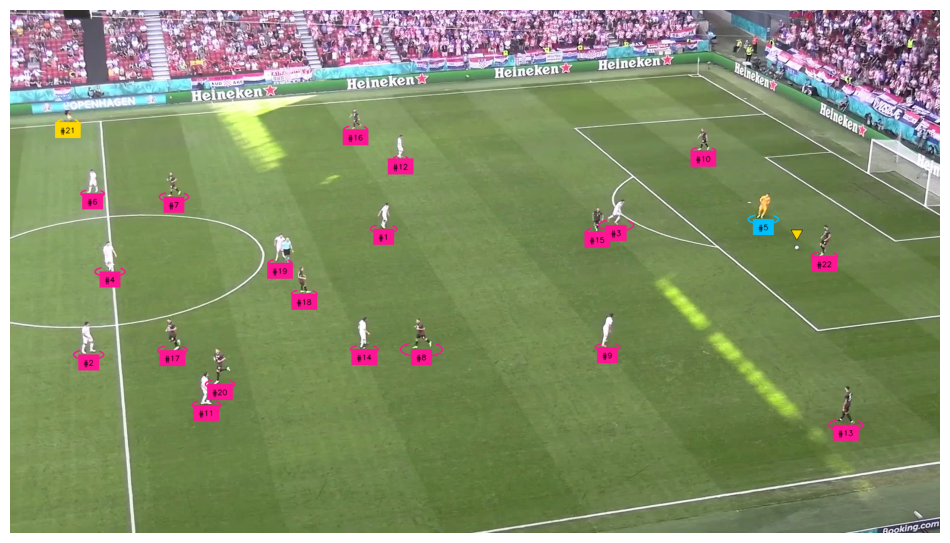

In [11]:
#Tracking IDs
BALL_ID = 0

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1 # remove ball class id
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

collecting crops: 1it [00:01,  1.75s/it]
Embedding extraction: 1it [00:08,  8.39s/it]


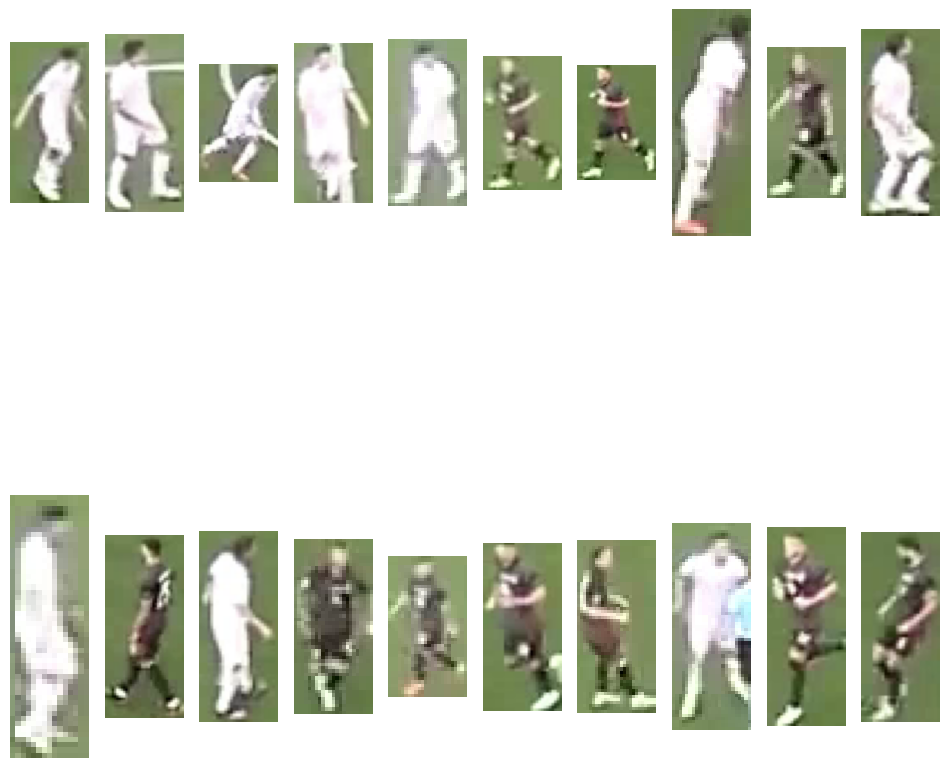

In [12]:
#Split teams
#use of the SigLIP, UMAP, and KMeans combo
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

PLAYER_ID = 2
STRIDE = 6000  

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE
)

crops = []
for frame in tqdm(frame_generator, desc="collecting crops"):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    
    # Skip the frame if no players are detected
    if len(players_detections.xyxy) == 0:
        continue
    
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    crops += players_crops

# Ensure there are enough crops for clustering
if len(crops) < 2:
    print("Not enough player crops detected. Skipping team classification.")
else:
    team_classifier = TeamClassifier(device="cpu")
    team_classifier.fit(crops)
    
sv.plot_images_grid(crops[:20], grid_size=(2, 10))

In [13]:
#GK Assignment - calculate avg centroid of players and assign GK to the team with the closest centroid

import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

Embedding extraction: 1it [00:09,  9.20s/it]


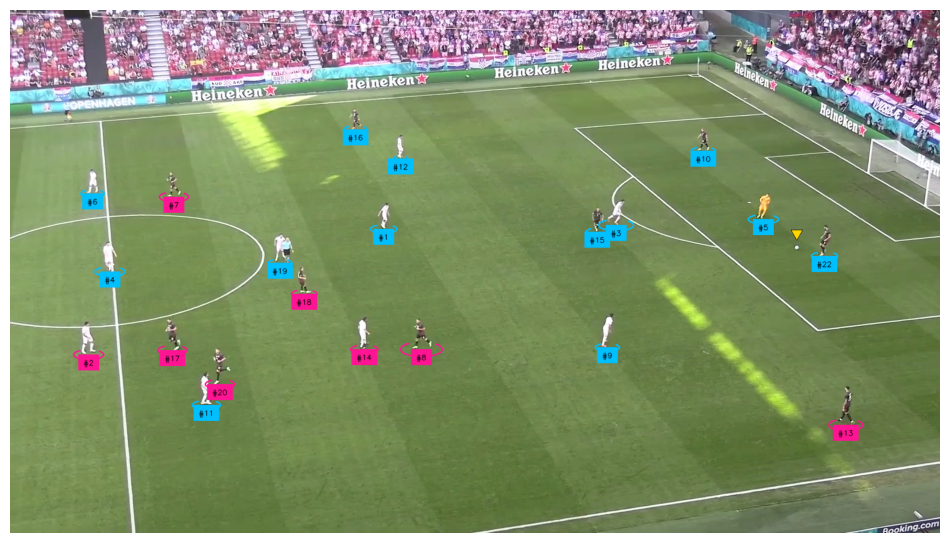

In [14]:
#Tracking with team assignment and gk assignment

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

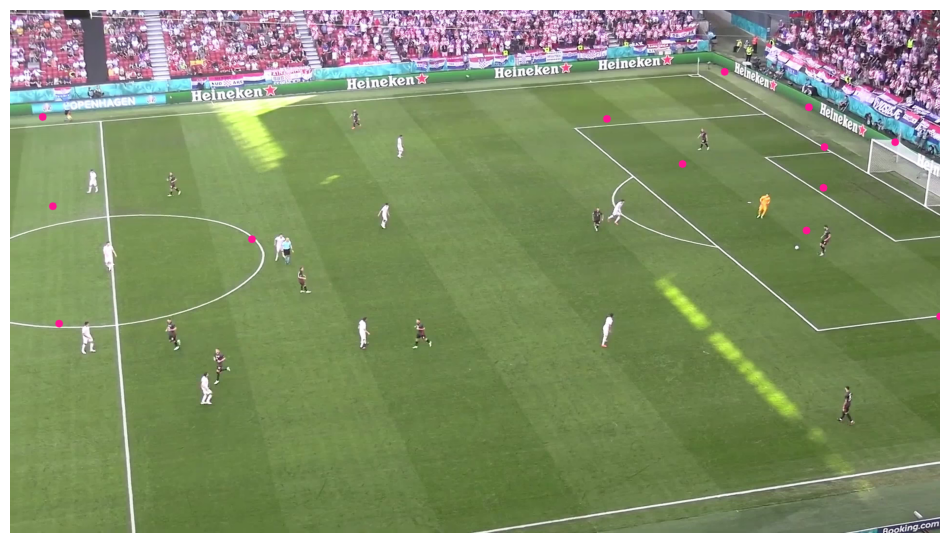

In [15]:
#Pitch Keypoint Detection
from inference import get_model

ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

import supervision as sv

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

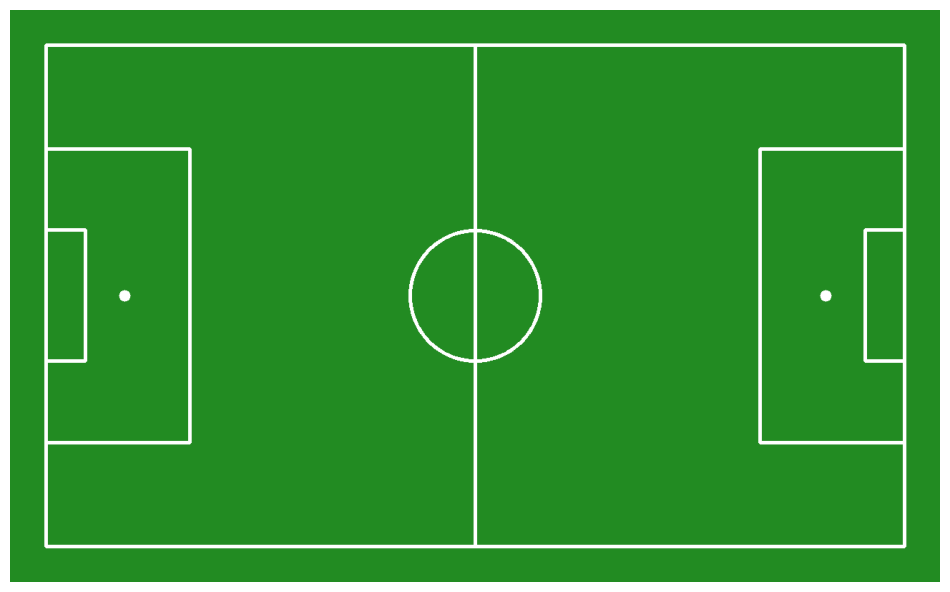

In [16]:
#acho que n é preciso
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

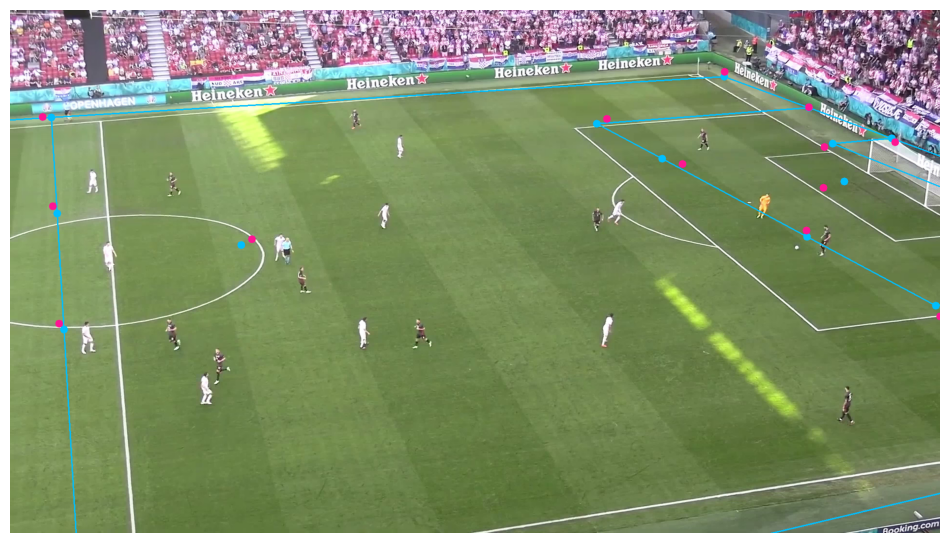

In [17]:
#project points and lines into the frame

import numpy as np
import supervision as sv
from sports.common.view import ViewTransformer

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# Filter keypoints based on confidence
filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

# Ensure there are at least 4 points for homography calculation
if len(frame_reference_points) < 4 or len(pitch_reference_points) < 4:
    print(f"Skipping frame {frame_index} due to insufficient keypoints: {len(frame_reference_points)} found.")
    
transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

In [18]:
#frame generator
from tqdm import tqdm

frames = []

for frame_index, frame in enumerate(tqdm(sv.get_video_frames_generator(SOURCE_VIDEO_PATH,start=10), desc="Processing...")):
    if frame_index % 5 == 0: 
        frames.append(frame)

print(f"Total frames collected: {len(frames)}")

Processing...: 142it [00:01, 114.64it/s]


Total frames collected: 29


In [20]:
import supervision as sv
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch
)

pitch_frames = []
virt_frames = []

ball_coords = []
gk_t1_coords = []
gk_t2_coords = []

team_0_coords = []
team_1_coords = []

# Tracker
tracker = sv.ByteTrack()

for frame_index, frame in enumerate(tqdm(frames, desc="Processing...")):
    tqdm.write(f"Frame {frame_index}")

    # ball, goalkeeper, player, referee detection
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
    
    # Save ball coordinates
    if len(ball_detections.xyxy) > 0:
        x_min, y_min, x_max, y_max = ball_detections.xyxy[0]  # Assuming one ball per frame
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        ball_coords.append((frame_index, x_center, y_center))
    else:
        ball_coords.append((frame_index, None, None))  # No ball detected in this frame

    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    all_detections = tracker.update_with_detections(detections=all_detections)

    goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
    players_detections = all_detections[all_detections.class_id == PLAYER_ID]

    # team assignment
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_detections.class_id = team_classifier.predict(players_crops)

    goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
        players_detections, goalkeepers_detections)
    
    # Save player coordinates per team (excluding goalkeepers)
    frame_team_0_coords = []
    frame_team_1_coords = []
    for player, team_id in zip(players_detections.xyxy, players_detections.class_id):
        x_min, y_min, x_max, y_max = player
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        if team_id == 0:
            frame_team_0_coords.append((x_center, y_center))  # Team 0 player coordinates
        elif team_id == 1:
            frame_team_1_coords.append((x_center, y_center))  # Team 1 player coordinates

    team_0_coords.append((frame_index, frame_team_0_coords))
    team_1_coords.append((frame_index, frame_team_1_coords))
    
    # Save goalkeeper coordinates for each team
    for gk, team_id in zip(goalkeepers_detections.xyxy, goalkeepers_detections.class_id):
        x_min, y_min, x_max, y_max = gk
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        if team_id == 0:
            gk_t1_coords.append((frame_index, x_center, y_center))
        elif team_id == 1:
            gk_t2_coords.append((frame_index, x_center, y_center))
    
    all_detections = sv.Detections.merge([players_detections, goalkeepers_detections])

    # frame visualization
    labels = [
        f"#{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
    ]

    all_detections.class_id = all_detections.class_id.astype(int)

    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections,
        labels=labels)
    annotated_frame = triangle_annotator.annotate(
        scene=annotated_frame,
        detections=ball_detections)

    pitch_frames.append(annotated_frame.copy())
    
    players_detections = sv.Detections.merge([
        players_detections, goalkeepers_detections
    ])

    # detect pitch key points
    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)
    
    # Ensure key_points is not None and contains valid data
    if key_points is None or key_points.confidence is None:
        print(f"Skipping frame {frame_index} due to missing key points.")
        continue  # Skip this frame and move to the next one

    # project ball, players and gk on pitch
    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    # Ensure there are at least 4 points for homography calculation
    if len(frame_reference_points) < 4 or len(pitch_reference_points) < 4:
        print(f"Skipping frame due to insufficient keypoints: {len(frame_reference_points)} found.")
        continue  # Skip this frame and move to the next one

    # Proceed with homography calculation
    transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

    players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_players_xy = transformer.transform_points(points=players_xy)

    # visualize video game-style radar view
    annotated_frame = draw_pitch(CONFIG)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_ball_xy,
        face_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=annotated_frame)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 0],
        face_color=sv.Color.from_hex('00BFFF'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 1],
        face_color=sv.Color.from_hex('FF1493'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame)

    virt_frames.append(annotated_frame.copy())  
    
    tracker.reset() 

Frame 0


Processing...:   0%|          | 0/29 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.47s/it]


Frame 1


Processing...:   3%|▎         | 1/29 [00:09<04:21,  9.34s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.42s/it]


Frame 2


Processing...:   7%|▋         | 2/29 [00:17<03:54,  8.67s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.25s/it]


Frame 3


Processing...:  10%|█         | 3/29 [00:25<03:36,  8.31s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.94s/it]


Frame 4


Processing...:  14%|█▍        | 4/29 [00:33<03:22,  8.09s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.14s/it]


Frame 5


Processing...:  17%|█▋        | 5/29 [00:41<03:13,  8.06s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.68s/it]


Frame 6


Processing...:  21%|██        | 6/29 [00:49<03:08,  8.21s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.28s/it]


Frame 7


Processing...:  24%|██▍       | 7/29 [00:58<03:06,  8.50s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.32s/it]


Frame 8


Processing...:  28%|██▊       | 8/29 [01:07<03:01,  8.66s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.96s/it]


Frame 9


Processing...:  31%|███       | 9/29 [01:15<02:48,  8.40s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.87s/it]


Frame 10


Processing...:  34%|███▍      | 10/29 [01:23<02:36,  8.23s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.24s/it]


Frame 11


Processing...:  38%|███▊      | 11/29 [01:31<02:28,  8.24s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.51s/it]


Frame 12


Processing...:  41%|████▏     | 12/29 [01:41<02:29,  8.81s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.52s/it]


Frame 13


Processing...:  45%|████▍     | 13/29 [01:51<02:27,  9.20s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.37s/it]


Frame 14


Processing...:  48%|████▊     | 14/29 [02:00<02:13,  8.91s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.35s/it]


Frame 15


Processing...:  52%|█████▏    | 15/29 [02:10<02:10,  9.33s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.49s/it]


Frame 16


Processing...:  55%|█████▌    | 16/29 [02:18<01:57,  9.02s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.44s/it]


Frame 17


Processing...:  59%|█████▊    | 17/29 [02:27<01:46,  8.87s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.87s/it]


Frame 18


Processing...:  62%|██████▏   | 18/29 [02:36<01:38,  8.93s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.11s/it]


Frame 19


Processing...:  66%|██████▌   | 19/29 [02:44<01:26,  8.61s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.32s/it]


Frame 20


Processing...:  69%|██████▉   | 20/29 [02:52<01:16,  8.45s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.67s/it]


Frame 21


Processing...:  72%|███████▏  | 21/29 [02:59<01:05,  8.17s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.34s/it]


Frame 22


Processing...:  76%|███████▌  | 22/29 [03:08<00:57,  8.24s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.70s/it]


Frame 23


Processing...:  79%|███████▉  | 23/29 [03:15<00:47,  8.00s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.60s/it]


Frame 24


Processing...:  83%|████████▎ | 24/29 [03:23<00:39,  7.88s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.75s/it]


Frame 25


Processing...:  86%|████████▌ | 25/29 [03:32<00:32,  8.16s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.35s/it]


Frame 26


Processing...:  90%|████████▉ | 26/29 [03:40<00:24,  8.15s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.85s/it]


Frame 27


Processing...:  93%|█████████▎| 27/29 [03:49<00:16,  8.35s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.38s/it]


Frame 28


Processing...:  97%|█████████▋| 28/29 [03:57<00:08,  8.32s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.78s/it]
Processing...: 100%|██████████| 29/29 [04:05<00:00,  8.48s/it]


In [22]:
import cv2
import numpy as np

output_dir = "../../data/frames/new5s-f"
os.makedirs(output_dir, exist_ok=True)

# Exemplo de como salvar os frames:
for idx, frame in enumerate(pitch_frames):
    frame_path = os.path.join(output_dir, f"frame_{idx:04d}.png")
    # Converter de RGB para BGR antes de salvar com OpenCV
    cv2.imwrite(frame_path, cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))

In [ ]:
#save data to csv
import csv
import pandas as pd

# Define the output file path
output_csv_path = "../../data/raw/new5s.csv"

# Save the data into a CSV file
with open(output_csv_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow([
        "frame_index", 
        "ball_coords", 
        "gk_t1_coords", 
        "gk_t2_coords", 
        "team_0_players", 
        "team_1_players"
    ])
    
    # Write the data for each frame
    for frame_index, ball_x, ball_y in ball_coords:
        # Get goalkeeper positions
        gk_t1_pos = next((pos for pos in gk_t1_coords if pos[0] == frame_index), (None, None, None))
        gk_t2_pos = next((pos for pos in gk_t2_coords if pos[0] == frame_index), (None, None, None))
        
        # Get player positions
        team_0_players = next((coords for idx, coords in team_0_coords if idx == frame_index), [])
        team_1_players = next((coords for idx, coords in team_1_coords if idx == frame_index), [])
        
        # Combine coordinates into single cells
        ball_coords_combined = f"({ball_x}, {ball_y})" if ball_x is not None and ball_y is not None else "None"
        gk_t1_coords_combined = f"({gk_t1_pos[1]}, {gk_t1_pos[2]})" if gk_t1_pos[1] is not None else "None"
        gk_t2_coords_combined = f"({gk_t2_pos[1]}, {gk_t2_pos[2]})" if gk_t2_pos[1] is not None else "None"
        
        # Write the row
        writer.writerow([
            frame_index,
            ball_coords_combined,
            gk_t1_coords_combined,
            gk_t2_coords_combined,
            str(team_0_players),  # Convert list of tuples to string
            str(team_1_players)   # Convert list of tuples to string
        ])

print(f"Coordinates saved to {output_csv_path}")